# Classification

Import the libraries necessary to analize data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydotplus
import scikitplot as skplt
import seaborn as sns
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import precision_score, recall_score, classification_report
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,  export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

ModuleNotFoundError: No module named 'numpy'

In [ ]:
df = pd.read_csv('../Task1/df_after_dp.csv', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       187534 non-null  datetime64[ns]
 1   state                      187534 non-null  object        
 2   city_or_county             187534 non-null  object        
 3   latitude                   187534 non-null  float64       
 4   longitude                  187534 non-null  float64       
 5   congressional_district     187534 non-null  int64         
 6   avg_age_participants       187534 non-null  float64       
 7   n_participants_child       187534 non-null  int64         
 8   n_participants_teen        187534 non-null  int64         
 9   n_females                  187534 non-null  float64       
 10  n_killed                   187534 non-null  float64       
 11  n_injured                  187534 non-null  float64 

In [ ]:
#df[(df["n_participants"] != 0) & (df['n_killed'] == (df["n_participants"] - (df["n_injured"] + df["n_unharmed"] + df["n_arrested"])))][["n_participants","n_killed","n_injured","n_unharmed","n_arrested"]]

In [ ]:
#check if there is any null value
df.isnull().values.any()

False

The calssification task requires to predict whether in the incident there were killed people. Hence we create the binary attribute isKilled

In [ ]:
df['isKilled'] = np.where(df['n_killed'] > 0, 1, 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       187534 non-null  datetime64[ns]
 1   state                      187534 non-null  object        
 2   city_or_county             187534 non-null  object        
 3   latitude                   187534 non-null  float64       
 4   longitude                  187534 non-null  float64       
 5   congressional_district     187534 non-null  int64         
 6   avg_age_participants       187534 non-null  float64       
 7   n_participants_child       187534 non-null  int64         
 8   n_participants_teen        187534 non-null  int64         
 9   n_females                  187534 non-null  float64       
 10  n_killed                   187534 non-null  float64       
 11  n_injured                  187534 non-null  float64 

## Discretize categorical values

We discretize the categorical values to use them in the classification task

In [ ]:
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [ ]:
to_discretize = ['date', 'state', 'city_or_county', 'party', 'incident_characteristics1']
df = discretize_data(df, to_discretize)

Dropping non-discretized columns

In [ ]:
df.drop(columns=['date', 'state', 'city_or_county', 'party', 'incident_characteristics1'], axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   latitude                       187534 non-null  float64
 1   longitude                      187534 non-null  float64
 2   congressional_district         187534 non-null  int64  
 3   avg_age_participants           187534 non-null  float64
 4   n_participants_child           187534 non-null  int64  
 5   n_participants_teen            187534 non-null  int64  
 6   n_females                      187534 non-null  float64
 7   n_killed                       187534 non-null  float64
 8   n_injured                      187534 non-null  float64
 9   n_arrested                     187534 non-null  float64
 10  n_unharmed                     187534 non-null  float64
 11  n_participants                 187534 non-null  float64
 12  povertyPercentage             

## Eliminating dependent columns

<Axes: >

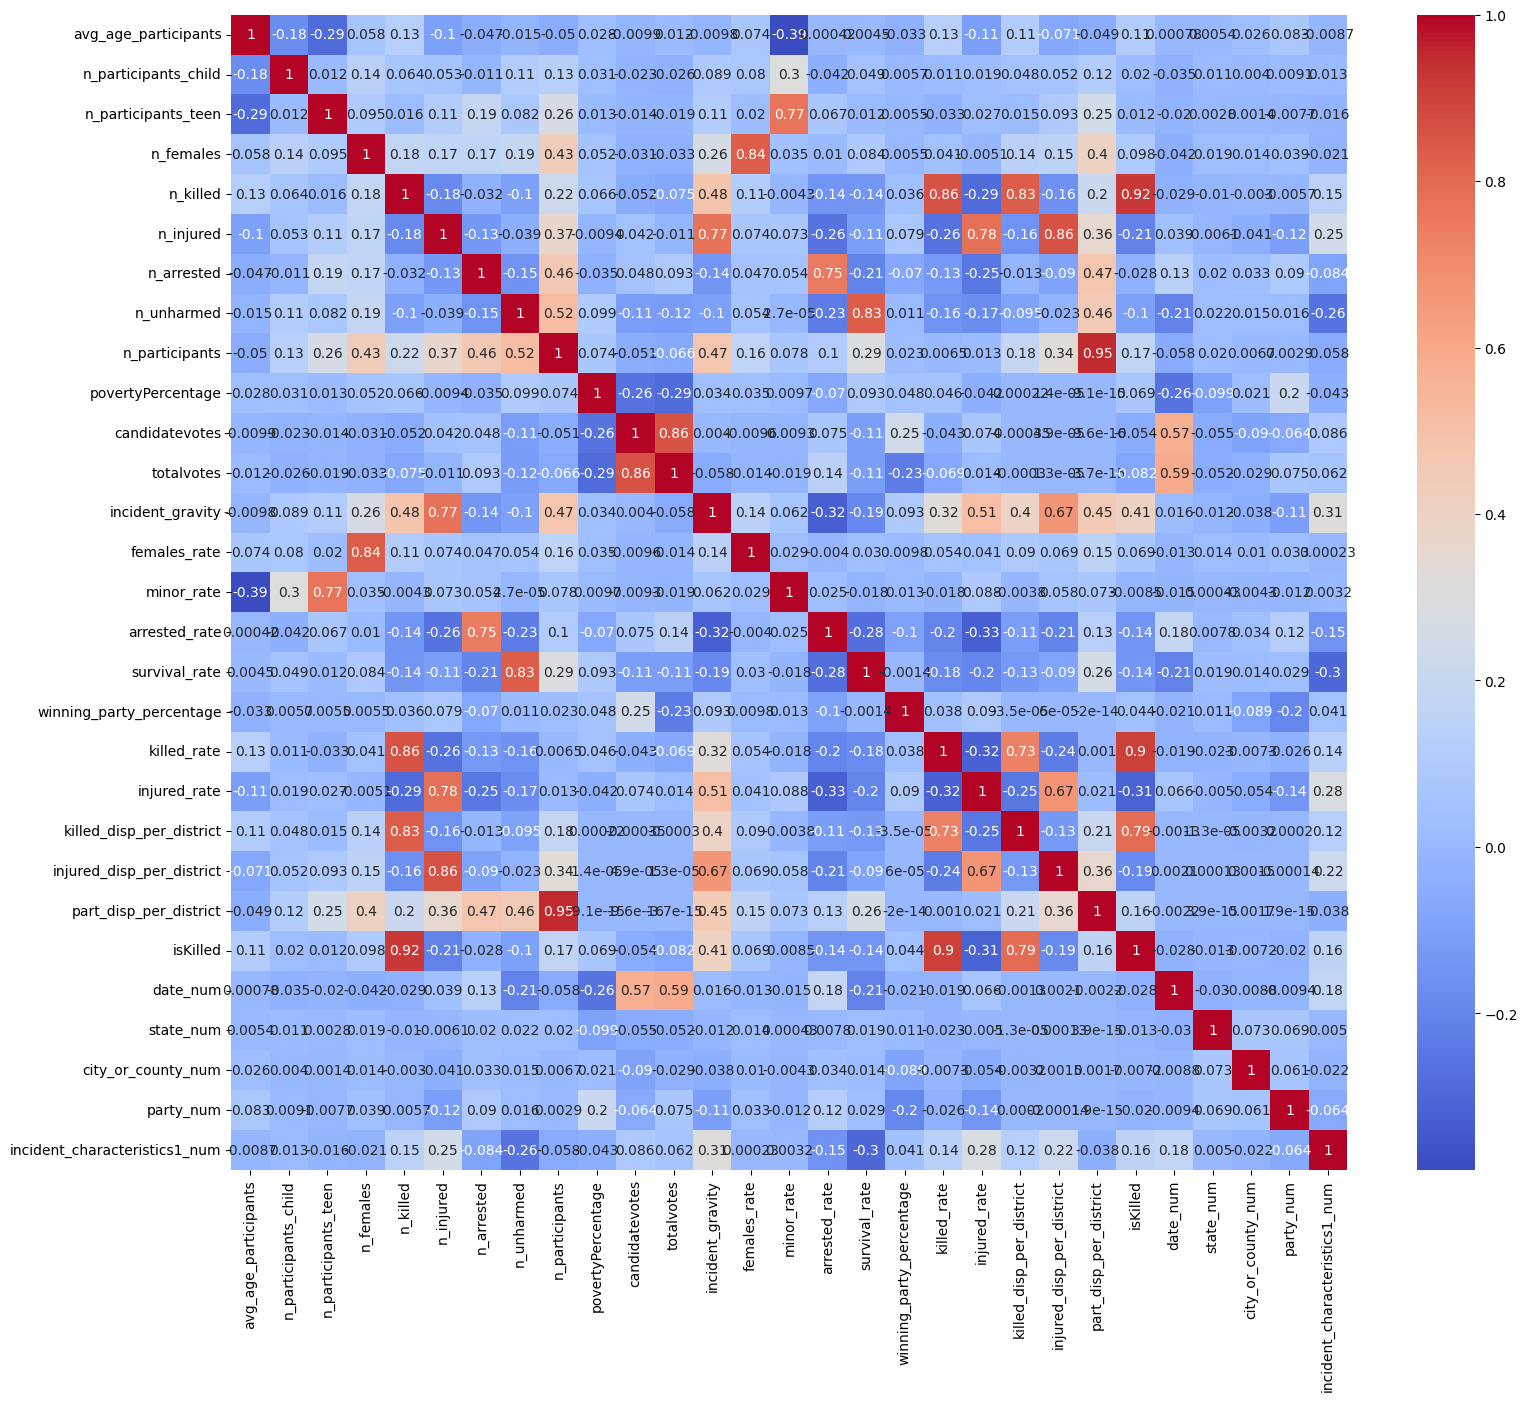

In [ ]:
col_to_plot = [i for i in list(df.columns) if i not in ['latitude', 'longitude', 'date','congressional_district']] 
corr_matrix_ind = df[col_to_plot].corr(numeric_only=True, method='pearson')
plt.figure(figsize=(18,15))
sns.heatmap(corr_matrix_ind, annot=True, cmap='coolwarm')

We drop all the cluster indicators as they are all highly correlated with original features, moreover we decide to drop also latitude and longitude as they represent a sort of incident id (each incident has a unique couple of values after the data preparation), n_killed because highly correlated with isKilled, candidatevotes and totalvotes because they are irrilevant and add only further details to the majority winning party represented already by the attribute party.   

In [ ]:
col_to_drop = ['latitude', 'longitude', 'n_killed', 'candidatevotes', 'totalvotes', 'incident_gravity', 'females_rate',
       'minor_rate', 'arrested_rate', 'survival_rate',  'killed_rate', 'injured_rate',
       'killed_disp_per_district', 'injured_disp_per_district',
       'part_disp_per_district', 'winning_party_percentage']

df.drop(columns=col_to_drop, axis=1,inplace=True)

<Axes: >

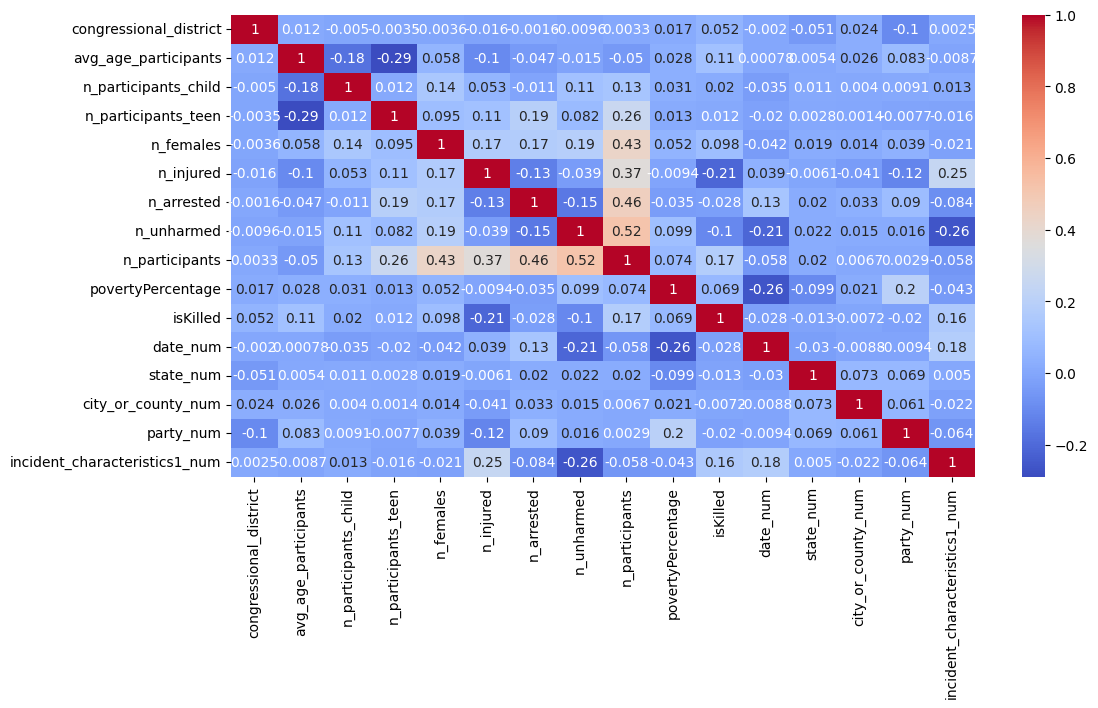

In [ ]:
plt.figure(figsize=(12,6))
corr_matrix_ind = df.corr(numeric_only=True, method='pearson')
corr_matrix_ind
sns.heatmap(corr_matrix_ind, annot=True, cmap='coolwarm')

## Classification setup

Check label distribution in order to understand if our dataset is unbalanced towards the negative label (no kill), 23% of labels is positive indeed. 

In [ ]:
df['isKilled'].value_counts(True)

isKilled
0    0.766176
1    0.233824
Name: proportion, dtype: float64

Defining a "label" variable for using stratified methods

In [ ]:
label = df.pop('isKilled')

We partitioned the dataset into training, validation, and test sets using a 70/30 split.

In [ ]:
X_trvl, X_test, y_trvl, y_test = train_test_split(df, label, test_size=0.30,random_state=10, stratify=label)

We standardize data and use oversampling and undersampling techniques to help classification methods to perform better 

over/undersampling on scaled dataset

In [ ]:
scaler = StandardScaler()
X_sc_trvl = scaler.fit_transform(X_trvl)
X_sc_test = scaler.fit_transform(X_test)

print(y_trvl.value_counts(True))


oversample = RandomOverSampler(sampling_strategy='minority',random_state=15)
X_sc_trvl_oversampled, y_trvl_oversampled = oversample.fit_resample(X_sc_trvl, y_trvl)
print(y_trvl_oversampled.value_counts(True))


undersample = RandomUnderSampler(sampling_strategy='majority',random_state=15)
X_sc_trvl_undersample, y_trvl_undersample = oversample.fit_resample(X_sc_trvl, y_trvl)
print(y_trvl_undersample.value_counts(True))


isKilled
0    0.766174
1    0.233826
Name: proportion, dtype: float64
isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64
isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64


over/undersampling on not scaled dataset

In [ ]:
print(y_trvl.value_counts(True))


oversample = RandomOverSampler(sampling_strategy='minority',random_state=15)
X_trvl_oversampled, y_trvl_oversampled = oversample.fit_resample(X_trvl, y_trvl)
print(y_trvl_oversampled.value_counts(True))


undersample = RandomUnderSampler(sampling_strategy='majority',random_state=15)
X_trvl_undersample, y_trvl_undersample = oversample.fit_resample(X_trvl, y_trvl)
print(y_trvl_undersample.value_counts(True))

isKilled
0    0.766174
1    0.233826
Name: proportion, dtype: float64


isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64
isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Defining some utility functions

In [ ]:
def print_metrics_cv(results_hp_search, model_name):
    index_best_model = results_hp_search.best_index_ 
    results_dict = results_hp_search.cv_results_
    metrics_list=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    print(f"CV best configuration for {model_name}:")
    print(f"best parameters {results_dict['params'][index_best_model]}")
    for i in metrics_list:
        print(f'Mean {i} train set: {results_dict[f"mean_train_{i}"][index_best_model]} +/- {results_dict[f"std_train_{i}"][index_best_model]}')
    print("\n")
    for i in metrics_list:
        print(f'Mean {i} validation set: {results_dict[f"mean_test_{i}"][index_best_model]} +/- {results_dict[f"std_test_{i}"][index_best_model]}')
    print("\n")

In [ ]:
# Function that prints the classification report
def print_report_score(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['NotKilled', 'isKilled']))

# Function that prints the confusion matrix
def print_confusion_matrix(test_label, pred_label, model):
    cm = confusion_matrix(test_label, pred_label)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

In [ ]:
# Function extracting each grid from dictionary of grids
def list_grids(grids_dict):
    return [grids_dict[item] for item in grids_dict]

# Function performing gridsearch cv according to sklearn
def do_sklearn_GridSearchCV(model_name,model,param_grid,scoring,refit,cv,return_train_score,n_jobs,X_encoded,y):
    hp_search = GridSearchCV(model,
                                param_grid=param_grid,
                                scoring=scoring,
                                refit=refit,
                                cv=cv,
                                return_train_score=return_train_score,
                                n_jobs=n_jobs,
                                verbose=2
                                ).fit(X_encoded, y)


    results = pd.DataFrame(hp_search.cv_results_)
    if not os.path.isdir(f"cv_results/"):
        os.mkdir(f"cv_results/")

    results.to_csv(f"cv_results/{model_name}_cv_results.csv")

    return hp_search

## Logistic Regression

In [29]:

"""     "l1": {"solver": ['saga', 'liblinear'],
           "C": [1e-1, 1e1, 1e4],
           "penalty": ['l1'],
           "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
           },
    "l2": {"solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky'],
           "C": [1e-1, 1e1, 1e4],
           "penalty": ['l2'],
           "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
           },
    "elastic-net": {"solver": ['saga'],
                    "C": [1e-1, 1e1, 1e4],
                    "penalty": ['elasticnet'],
                    "l1_ratio": np.arange(0.0, 1.1, 0.1),
                  "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}, {0:1,1:100}]
                    }, """
params = {


    "None": {"solver": ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
             "penalty": [None],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
             }
}

best_logit = do_sklearn_GridSearchCV("LogisticRegression",LogisticRegression(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [53]:
#df_logit = pd.DataFrame(best_logit.cv_results_)
#df_logit.sort_values(by="rank_test_accuracy")[["params", "rank_test_accuracy",  "mean_train_accuracy", "mean_test_accuracy", "mean_test_precision",  "mean_train_precision","mean_test_recall", "mean_test_f1", "mean_test_roc_auc"]]

CV best configuration for LogisticRegression:
best parameters {'class_weight': None, 'penalty': None, 'solver': 'lbfgs'}
Mean accuracy train set: 0.9781371640992802 +/- 0.00013297274168303777
Mean precision train set: 0.9341290013005723 +/- 0.0008023252668875722
Mean recall train set: 0.9752728457403486 +/- 0.00042352174621273456
Mean f1 train set: 0.9542572583232429 +/- 0.0002520053133959154
Mean roc_auc train set: 0.9815634582920986 +/- 0.0001157353972495151


Mean accuracy validation set: 0.978129539096668 +/- 0.0005766311583873195
Mean precision validation set: 0.9341451161794507 +/- 0.003504664762517609
Mean recall validation set: 0.9752402671444861 +/- 0.0017784452274254442
Mean f1 validation set: 0.9542432534846631 +/- 0.0010845566996613048
Mean roc_auc validation set: 0.981483725596414 +/- 0.0002549927332016887


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.98      0.99     43106
    isKilled       0.94      0.98      0.96     1

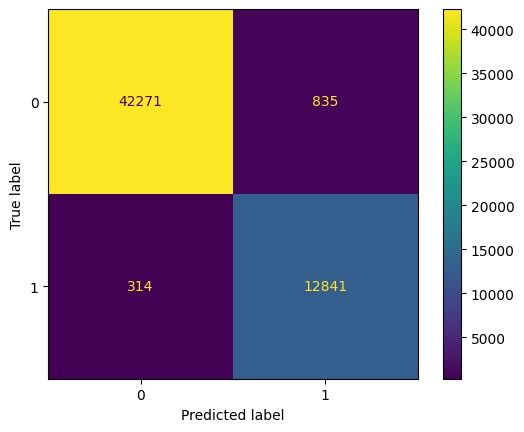

In [30]:
print_metrics_cv(best_logit,"LogisticRegression")
print("Testing:")
test_pred_logit = best_logit.predict(X_sc_test)

print_report_score(y_test,test_pred_logit)
print_confusion_matrix(y_test,test_pred_logit,best_logit)

Oversampling

In [31]:
best_logit_ov = do_sklearn_GridSearchCV("LogisticRegression_OV",LogisticRegression(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


CV best configuration for LogisticRegression_OV:
best parameters {'class_weight': None, 'penalty': None, 'solver': 'sag'}
Mean accuracy train set: 0.976659905667421 +/- 0.00022166866315059968
Mean precision train set: 0.9772530763099025 +/- 0.0002734308858377855
Mean recall train set: 0.9760384982250538 +/- 0.00018017422829530894
Mean f1 train set: 0.9766454046121824 +/- 0.00022057681575043101
Mean roc_auc train set: 0.9830459585500764 +/- 0.0002854552507469593


Mean accuracy validation set: 0.9766300773798859 +/- 0.001057909387822584
Mean precision validation set: 0.9771957455826407 +/- 0.001407007085110056
Mean recall validation set: 0.9760385093329186 +/- 0.0007206954207849583
Mean f1 validation set: 0.9766166342082073 +/- 0.0010495684587864824
Mean roc_auc validation set: 0.9829959768917451 +/- 0.0010299345468784782


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.98      0.99     43106
    isKilled       0.93      0.98      0.95    

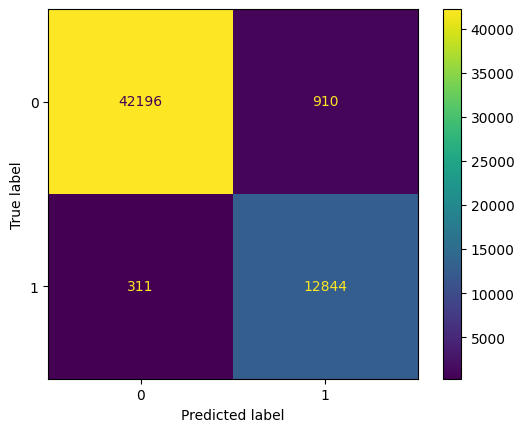

In [32]:
print_metrics_cv(best_logit_ov,"LogisticRegression_OV")
print("Testing:")
test_pred_logit_ov = best_logit_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_logit_ov)
print_confusion_matrix(y_test,test_pred_logit_ov,best_logit_ov)

Undersampling

In [33]:
best_logit_und = do_sklearn_GridSearchCV("LogisticRegression_UN",LogisticRegression(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


CV best configuration for LogisticRegression_UN:
best parameters {'class_weight': 'balanced', 'penalty': None, 'solver': 'sag'}
Mean accuracy train set: 0.976659905667421 +/- 0.00022166866315059968
Mean precision train set: 0.9772530763099025 +/- 0.0002734308858377855
Mean recall train set: 0.9760384982250538 +/- 0.00018017422829530894
Mean f1 train set: 0.9766454046121824 +/- 0.00022057681575043101
Mean roc_auc train set: 0.9830457572592513 +/- 0.0002852673597501315


Mean accuracy validation set: 0.9766300773798859 +/- 0.001057909387822584
Mean precision validation set: 0.9771957455826407 +/- 0.001407007085110056
Mean recall validation set: 0.9760385093329186 +/- 0.0007206954207849583
Mean f1 validation set: 0.9766166342082073 +/- 0.0010495684587864824
Mean roc_auc validation set: 0.9829956719236019 +/- 0.001030311625340199


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.98      0.99     43106
    isKilled       0.93      0.98      0.9

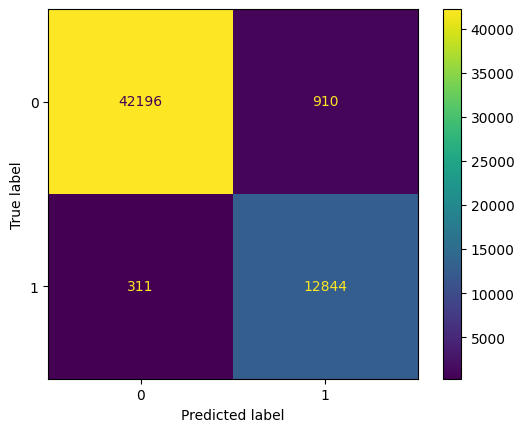

In [34]:
print_metrics_cv(best_logit_und,"LogisticRegression_UN")
print("Testing:")
test_pred_logit_und = best_logit_und.predict(X_sc_test)

print_report_score(y_test,test_pred_logit_und)
print_confusion_matrix(y_test,test_pred_logit_und,best_logit_und)

## KNN

KNN works using a distance function, but distance can not be applied to categorical data. We need to handle categorical values, for example we could drop them.

We define the KNN calssifier by specifying the algorithm and the distance metric to use and we fit it to our data.

In [57]:
metrics = [
    'euclidean', 
    #'minkowski',
    #'chebyshev',
    #'cosine',
    ]
params = {
        "unique_entry":{
        'n_neighbors': [10,100,500],
        #'algorithm':['auto','ball_tree'], 
        'metric':metrics, 
        #'weights':["distance","uniform"],
        #'p': [1]
        }}
         
best_knn = do_sklearn_GridSearchCV("KNeighborsClassifier",KNeighborsClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


We run the prediction and evaluate the performance scores for this model.

In [ ]:
print_metrics_cv(best_knn,"KNeighborsClassifier")
print("Testing:")
test_pred_knn = best_knn.predict(X_sc_test)

print_report_score(y_test,test_pred_knn)
print_confusion_matrix(y_test,test_pred_knn,best_knn)

In [ ]:
plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_knn.values, s=25, cmap='YlGn')


Oversampled

In [ ]:
best_knn_ov = do_sklearn_GridSearchCV("KNeighborsClassifier_OV",KNeighborsClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled)

In [ ]:
print_metrics_cv(best_knn_ov,"KNeighborsClassifier_OV")
print("Testing:")
test_pred_knn_ov = best_knn_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_knn_ov)
print_confusion_matrix(y_test,test_pred_knn_ov,best_knn_ov)

Undersampled

In [ ]:
best_knn_und = do_sklearn_GridSearchCV("KNeighborsClassifier_UN",KNeighborsClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)

In [ ]:
print_metrics_cv(best_knn_und,"KNeighborsClassifier_UN")
print("Testing:")
test_pred_knn_und = best_knn_und.predict(X_sc_test)

print_report_score(y_test,test_pred_knn_und)
print_confusion_matrix(y_test,test_pred_knn_und,best_knn_und)

## Naive Bayes

Bayes theorem is used to compute the probability of an instance belonging to a given class given some prior knowledge.
We fit the model on our training data.

We chose the best among the classifiers, based on validation set and tested it.

In [31]:
from sklearn.naive_bayes import GaussianNB


best_gnb_cv = do_sklearn_GridSearchCV("GaussianNB",GaussianNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


In [32]:
print_metrics_cv(results_hp_search=best_gnb_cv, model_name='GaussianNB')

CV best configuration for GaussianNB:
best parameters {}
Mean accuracy train set: 0.8561376012716553 +/- 0.0035473013302933965
Mean precision train set: 0.6621763148677855 +/- 0.004049480262748528
Mean recall train set: 0.7854536569473856 +/- 0.02400309163645098
Mean f1 train set: 0.7184101800513234 +/- 0.010757114523271955
Mean roc_auc train set: 0.8944901939462266 +/- 0.0014578464149025182


Mean accuracy validation set: 0.8558042771496602 +/- 0.0029912190692628756
Mean precision validation set: 0.6617281325255171 +/- 0.004005960021353937
Mean recall validation set: 0.7843296953901286 +/- 0.02315717210618791
Mean f1 validation set: 0.717664274766181 +/- 0.009719306248916313
Mean roc_auc validation set: 0.8943219870533088 +/- 0.0012664817752625834




In [33]:
from sklearn.naive_bayes import BernoulliNB

best_bnb_cv = do_sklearn_GridSearchCV("BernoulliNB",BernoulliNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


In [34]:
print_metrics_cv(results_hp_search=best_bnb_cv, model_name='BernoulliNB')

CV best configuration for BernoulliNB:
best parameters {}
Mean accuracy train set: 0.7836779083816865 +/- 0.00014191271427727983
Mean precision train set: 0.9105209969137343 +/- 0.00747867859392625
Mean recall train set: 0.08303469620459357 +/- 0.0013378066290553631
Mean f1 train set: 0.15218379004750648 +/- 0.0021498949515216443
Mean roc_auc train set: 0.8284537680788695 +/- 0.0007738311421570178


Mean accuracy validation set: 0.783611265982674 +/- 0.0010334839304783497
Mean precision validation set: 0.9088568612025114 +/- 0.01189457070348238
Mean recall validation set: 0.0828473692783841 +/- 0.0037253734768327913
Mean f1 validation set: 0.15183926886673701 +/- 0.006416814959687437
Mean roc_auc validation set: 0.828303937013052 +/- 0.002991755753815365




In [35]:
from sklearn.naive_bayes import MultinomialNB

best_mnb_cv = do_sklearn_GridSearchCV("MultinomialNB",MultinomialNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


In [36]:
print_metrics_cv(results_hp_search=best_mnb_cv, model_name='MultinomialNB')

CV best configuration for MultinomialNB:
best parameters {}
Mean accuracy train set: 0.5514062334333043 +/- 0.004847453803732562
Mean precision train set: 0.2567267580953735 +/- 0.0015332736992575645
Mean recall train set: 0.4845496009122007 +/- 0.005088848108365343
Mean f1 train set: 0.33560846874834216 +/- 0.0002925382258287394
Mean roc_auc train set: 0.5398737332592107 +/- 0.003113599024505562


Mean accuracy validation set: 0.5514842587054087 +/- 0.008176526955790993
Mean precision validation set: 0.25695778708028577 +/- 0.005457827229910166
Mean recall validation set: 0.48506271379703536 +/- 0.006249148777128549
Mean f1 validation set: 0.33592431459003025 +/- 0.005577794576628838
Mean roc_auc validation set: 0.5398470451767194 +/- 0.01004791344262803




In [37]:
from sklearn.naive_bayes import ComplementNB

best_cnb_cv = do_sklearn_GridSearchCV("ComplementNB",ComplementNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s


In [38]:
print_metrics_cv(results_hp_search=best_cnb_cv, model_name='ComplementNB')

CV best configuration for ComplementNB:
best parameters {}
Mean accuracy train set: 0.534555851637033 +/- 0.002588212297309614
Mean precision train set: 0.255247075795776 +/- 0.001244937598224163
Mean recall train set: 0.5164847695064344 +/- 0.0006888851752334551
Mean f1 train set: 0.3416475244318182 +/- 0.0009802455891971885
Mean roc_auc train set: 0.5398652991414836 +/- 0.0031216579162174204


Mean accuracy validation set: 0.5351138093572979 +/- 0.005815021244656406
Mean precision validation set: 0.25552196204088407 +/- 0.004490235897756055
Mean recall validation set: 0.5163055872291904 +/- 0.007636606331053003
Mean f1 validation set: 0.34184926877393373 +/- 0.005458040099205391
Mean roc_auc validation set: 0.5398405870743987 +/- 0.010051289192042989




Best so far is GaussianNB, we testing it also with oversampling and undersampling techniques.

Testing:
              precision    recall  f1-score   support

   NotKilled       0.93      0.88      0.90     43106
    isKilled       0.66      0.78      0.72     13155

    accuracy                           0.86     56261
   macro avg       0.80      0.83      0.81     56261
weighted avg       0.87      0.86      0.86     56261



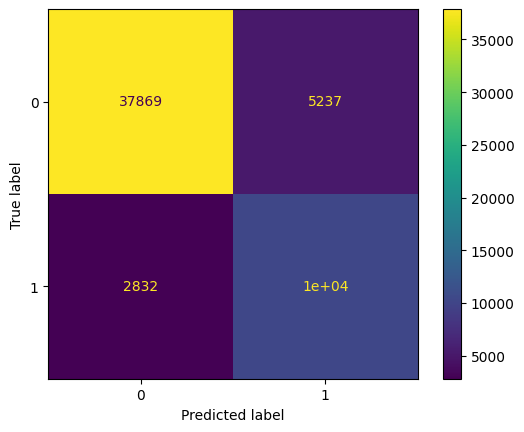

In [39]:
print("Testing:")
test_pred_gnb = best_gnb_cv.predict(X_test)
print_report_score(y_test,test_pred_gnb)
print_confusion_matrix(y_test,test_pred_gnb,best_gnb_cv)

oversampling

In [40]:
best_gnb_balanced_ov = do_sklearn_GridSearchCV("GaussianNB_OV",GaussianNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_trvl_oversampled,y_trvl_oversampled)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


CV best configuration for GaussianNB_OV:
best parameters {}
Mean accuracy train set: 0.7472869350543025 +/- 0.0035881674653820204
Mean precision train set: 0.6755262791363921 +/- 0.0031232752368840237
Mean recall train set: 0.9517439259906961 +/- 0.0013639834406489074
Mean f1 train set: 0.7901899694428481 +/- 0.002579256998283355
Mean roc_auc train set: 0.8957640153162556 +/- 0.0009369164146972369


Mean accuracy validation set: 0.7469724862531922 +/- 0.005159216115391393
Mean precision validation set: 0.6752703022472477 +/- 0.004355558191444009
Mean recall validation set: 0.9515897879299813 +/- 0.002372455244529954
Mean f1 validation set: 0.7899607586952313 +/- 0.0037909706247199687
Mean roc_auc validation set: 0.8956185014373903 +/- 0.001499188440156002


Testing:
              precision    recall  f1-score   support

   NotKilled       0.78      0.93      0.85     43106
    isKilled       0.34      0.11      0.17     13155

    accuracy                           0.74     56261
   ma

c:\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


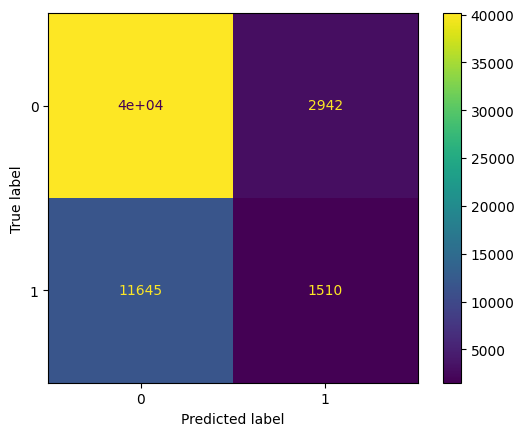

In [41]:
print_metrics_cv(best_gnb_balanced_ov,"GaussianNB_OV")
print("Testing:")
test_pred_gnb_over = best_gnb_balanced_ov.predict(X_test)

print_report_score(y_test,test_pred_gnb_over)
print_confusion_matrix(y_test,test_pred_gnb_over,best_gnb_balanced_ov)

Undersampling

In [42]:
best_gnb_balanced_und = do_sklearn_GridSearchCV("GaussianNB_UN",GaussianNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_trvl_undersample,y_trvl_undersample)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


CV best configuration for GaussianNB_UN:
best parameters {}
Mean accuracy train set: 0.7472869350543025 +/- 0.0035881674653820204
Mean precision train set: 0.6755262791363921 +/- 0.0031232752368840237
Mean recall train set: 0.9517439259906961 +/- 0.0013639834406489074
Mean f1 train set: 0.7901899694428481 +/- 0.002579256998283355
Mean roc_auc train set: 0.8957640153162556 +/- 0.0009369164146972369


Mean accuracy validation set: 0.7469724862531922 +/- 0.005159216115391393
Mean precision validation set: 0.6752703022472477 +/- 0.004355558191444009
Mean recall validation set: 0.9515897879299813 +/- 0.002372455244529954
Mean f1 validation set: 0.7899607586952313 +/- 0.0037909706247199687
Mean roc_auc validation set: 0.8956185014373903 +/- 0.001499188440156002


Testing:
              precision    recall  f1-score   support

   NotKilled       0.97      0.54      0.70     43106
    isKilled       0.39      0.95      0.55     13155

    accuracy                           0.64     56261
   ma

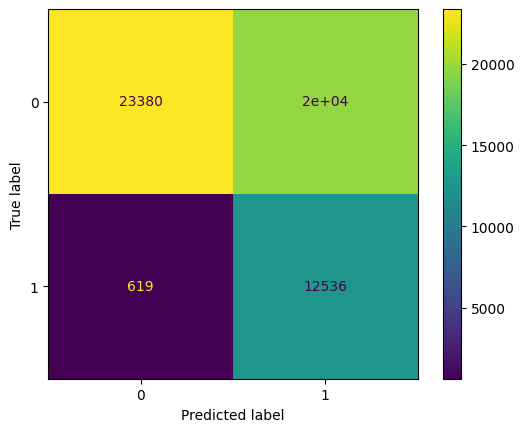

In [43]:
print_metrics_cv(best_gnb_balanced_ov,"GaussianNB_UN")
print("Testing:")
test_pred_gnb_und = best_gnb_balanced_und.predict(X_test)

print_report_score(y_test,test_pred_gnb_und)
print_confusion_matrix(y_test,test_pred_gnb_und,best_gnb_balanced_und)

We plotted the scatter plot for the classification values on the test set.

In [44]:
#plt.scatter(X_test.iloc[:, 5], X_test.iloc[:, 6], c=test_pred_gnb, s=25, cmap='YlGn')

## Decision tree

We fit the decision tree on our training data.

In [ ]:
params = {
        "unique_entry": {
        'criterion': ['gini', 'entropy','log_loss'],
        'max_depth': [5,10,None],
        'max_features': ['sqrt', 'log2', None],
        'min_samples_split': [2,8,16,32],
        'min_samples_leaf': [1,2,4,8],
        "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
        }
        }
best_tree_cv = do_sklearn_GridSearchCV("DecisionTreeClassifier",DecisionTreeClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[CV] END .....................................criterion=gini; total time=   0.6s
[CV] END .....................................criterion=gini; total time=   0.4s
[CV] END .....................................criterion=gini; total time=   0.4s
[CV] END .....................................criterion=gini; total time=   0.4s
[CV] END .....................................criterion=gini; total time=   0.4s
[CV] END ..................................criterion=entropy; total time=   0.3s
[CV] END ..................................criterion=entropy; total time=   0.3s
[CV] END ..................................criterion=entropy; total time=   0.3s
[CV] END ..................................criterion=entropy; total time=   0.3s
[CV] END ..................................criterion=entropy; total time=   0.3s
[CV] END .................................criterion=log_loss; total time=   0.4s
[CV] END .................................criterion=log_loss; total time=   0.4s
[CV] END ...................

In [ ]:
print_metrics_cv(results_hp_search=best_tree_cv, model_name='DecisionTreeClassifier')

CV best configuration for DecisionTreeClassifier:
best parameters {'criterion': 'log_loss'}
Mean accuracy train set: 1.0 +/- 0.0
Mean precision train set: 1.0 +/- 0.0
Mean recall train set: 1.0 +/- 0.0
Mean f1 train set: 1.0 +/- 0.0
Mean roc_auc train set: 1.0 +/- 0.0


Mean accuracy validation set: 0.9814737168325427 +/- 0.0005761296632739523
Mean precision validation set: 0.9600099390903154 +/- 0.0031659838338764174
Mean recall validation set: 0.9608079491773905 +/- 0.0021402922568049456
Mean f1 validation set: 0.960402613843117 +/- 0.0011777860865855735
Mean roc_auc validation set: 0.9742942793273013 +/- 0.0008132282620074938




This yields the following decision tree.

In [ ]:
""" dot_data = export_graphviz(best_tree_cv.best_estimator_, out_file=None, 
                         feature_names=list(X_trvl.columns),  
                         class_names=['0', '1'],
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) """

" dot_data = export_graphviz(best_tree_cv.best_estimator_, out_file=None, \n                         feature_names=list(X_trvl.columns),  \n                         class_names=['0', '1'],\n                         filled=True, rounded=True)  \ngraph = pydotplus.graph_from_dot_data(dot_data)  \nImage(graph.create_png()) "

The predicted values of TS, obtained using the decision tree are then computed.

Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.96      0.96      0.96     13155

    accuracy                           0.98     56261
   macro avg       0.98      0.98      0.98     56261
weighted avg       0.98      0.98      0.98     56261



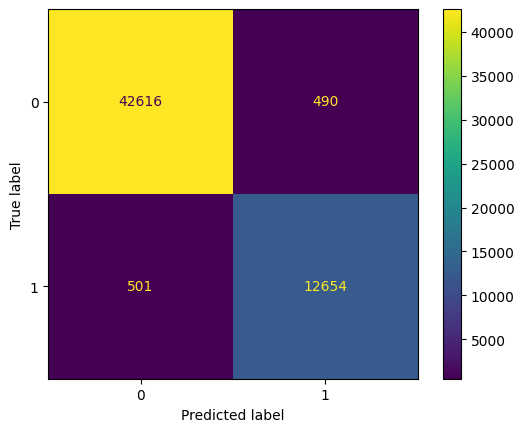

In [ ]:
test_pred_dt = best_tree_cv.predict(X_sc_test)
print("Testing:")
print_report_score(y_test,test_pred_dt)
print_confusion_matrix(y_test, test_pred_dt, best_tree_cv)

In [ ]:
# TODO We plotted the scatter plot for the classification values on the test set ???
#plt.scatter(X_sc_test.iloc[:, 5].values, X_sc_test.iloc[:, 2].values, c=test_pred_dt.values, s=25, cmap='YlGn')

Oversampling

In [ ]:

#TODO CAPIRE SE ricalcolare lag grid per _oversampled oppure mantenere i parametri scelti dalla grid per il dataset di base
best_tree_balanced_ov = do_sklearn_GridSearchCV("DecisionTreeClassifier_OV",DecisionTreeClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .....................................criterion=gini; total time=   1.0s
[CV] END .....................................criterion=gini; total time=   1.1s
[CV] END .....................................criterion=gini; total time=   0.9s
[CV] END .....................................criterion=gini; total time=   0.7s
[CV] END .....................................criterion=gini; total time=   0.7s
[CV] END ..................................criterion=entropy; total time=   0.8s
[CV] END ..................................criterion=entropy; total time=   0.9s
[CV] END ..................................criterion=entropy; total time=   1.1s
[CV] END ..................................criterion=entropy; total time=   0.7s
[CV] END ..................................criterion=entropy; total time=   0.6s
[CV] END .................................criterion=log_loss; total time=   0.6s
[CV] END .................................criteri

CV best configuration for DecisionTreeClassifier_OV:
best parameters {'criterion': 'log_loss'}
Mean accuracy train set: 1.0 +/- 0.0
Mean precision train set: 1.0 +/- 0.0
Mean recall train set: 1.0 +/- 0.0
Mean f1 train set: 1.0 +/- 0.0
Mean roc_auc train set: 1.0 +/- 0.0


Mean accuracy validation set: 0.9920211171961343 +/- 0.0004534642959007463
Mean precision validation set: 0.9869819644214569 +/- 0.000969764326008422
Mean recall validation set: 0.9971962078063068 +/- 0.0005285457718015157
Mean f1 validation set: 0.9920623771313654 +/- 0.0004475992379445003
Mean roc_auc validation set: 0.9920211120022883 +/- 0.0004535648308297839


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.96      0.96      0.96     13155

    accuracy                           0.98     56261
   macro avg       0.98      0.97      0.98     56261
weighted avg       0.98      0.98      0.98     56261



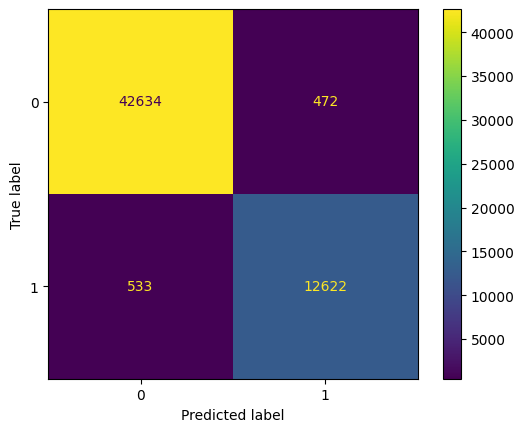

In [ ]:
print_metrics_cv(results_hp_search=best_tree_balanced_ov, model_name='DecisionTreeClassifier_OV')


print("Testing:")
test_pred_dt_over = best_tree_balanced_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_dt_over)
print_confusion_matrix(y_test,test_pred_dt_over,best_tree_balanced_ov)

Undersampling 

In [ ]:
best_tree_balanced_und = do_sklearn_GridSearchCV("DecisionTreeClassifier_UN",DecisionTreeClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,1,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .....................................criterion=gini; total time=   0.9s
[CV] END .....................................criterion=gini; total time=   1.2s
[CV] END .....................................criterion=gini; total time=   1.1s
[CV] END .....................................criterion=gini; total time=   1.0s
[CV] END .....................................criterion=gini; total time=   1.0s
[CV] END ..................................criterion=entropy; total time=   0.9s
[CV] END ..................................criterion=entropy; total time=   0.8s
[CV] END ..................................criterion=entropy; total time=   0.9s
[CV] END ..................................criterion=entropy; total time=   0.9s
[CV] END ..................................criterion=entropy; total time=   0.9s
[CV] END .................................criterion=log_loss; total time=   0.8s
[CV] END .................................criteri

CV best configuration for DecisionTreeClassifier_UN:
best parameters {'criterion': 'entropy'}
Mean accuracy train set: 1.0 +/- 0.0
Mean precision train set: 1.0 +/- 0.0
Mean recall train set: 1.0 +/- 0.0
Mean f1 train set: 1.0 +/- 0.0
Mean roc_auc train set: 1.0 +/- 0.0


Mean accuracy validation set: 0.9921951115090231 +/- 0.0004482566232409697
Mean precision validation set: 0.9873506314193156 +/- 0.0009048326284224864
Mean recall validation set: 0.9971663808029264 +/- 0.000535417892909882
Mean f1 validation set: 0.99223386772385 +/- 0.00044319813556801234
Mean roc_auc validation set: 0.9921951065624004 +/- 0.0004483580095006481


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.96      0.96      0.96     13155

    accuracy                           0.98     56261
   macro avg       0.98      0.98      0.98     56261
weighted avg       0.98      0.98      0.98     56261



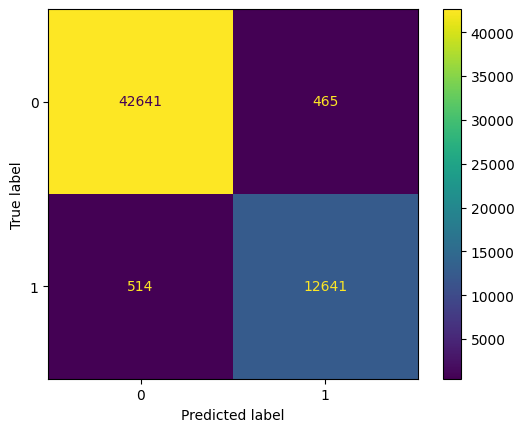

In [ ]:
print_metrics_cv(results_hp_search=best_tree_balanced_und, model_name='DecisionTreeClassifier_UN')

print("Testing:")
test_pred_dt_under = best_tree_balanced_und.predict(X_sc_test)
print_report_score(y_test,test_pred_dt_under)
print_confusion_matrix(y_test,test_pred_dt_under,best_tree_balanced_und)

## SVM

In [21]:
params = {
  #"linear_rbf_sigmoid": {
   #"kernel": ['linear', 'rbf','sigmoid'],
   #"C":[1e-4,1e-1,1e1,1e4],
   #"gamma" : ['scale', 'auto],
   #"tol": [1e-4, 1e-8, 1e-2],
   #"random_state": [42],
   #"class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
  #},
  "poly": {
    "kernel": ['poly'],
    #"C":[1e-4,1e-1,1e1,1e4],
    #"degree": [2,3,5],
    #"gamma" : ['scale', 'auto'],
    #"tol": [1e-4, 1e-8, 1e-2],
    "random_state": [42],
    #"class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
  }
    } 

best_svc = do_sklearn_GridSearchCV("SVC",SVC(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


We run the prediction on our test set.

In [ ]:
print_metrics_cv(best_svc,"SVC")
print("Testing:")
test_pred_svc = best_svc.predict(X_sc_test)

print_report_score(y_test,test_pred_svc)
print_confusion_matrix(y_test,test_pred_svc,best_svc)

Fitting 5 folds for each of 756 candidates, totalling 3780 fits


KeyboardInterrupt: 

Oversampling

In [ ]:
best_svc_ov = do_sklearn_GridSearchCV("SVC_OV",SVC(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,1,X_sc_trvl_oversampled,y_trvl_oversampled)

In [ ]:
print_metrics_cv(best_svc_ov,"SVC_OV")
print("Testing:")
test_pred_svc_ov = best_svc_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_svc_ov)
print_confusion_matrix(y_test,test_pred_svc_ov,best_svc_ov)

Undersampling

In [ ]:
best_svc_und = do_sklearn_GridSearchCV("SVC_UN",SVC(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,1,X_sc_trvl_undersample,y_trvl_undersample)
print_metrics_cv(best_svc_und,"SVC_UN")
print("Testing:")
test_pred_svc_und = best_svc_und.predict(X_sc_test)

print_report_score(y_test,test_pred_svc_und)
print_confusion_matrix(y_test,test_pred_svc_und,best_svc_und)

We plot the ROC curve in order to estimate the goodness of our classification.

In [ ]:
plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_svc.values, s=25, cmap='YlGn')


## Rule-based classification

In order to run the RIPPER classifier, we run a grip search to find the best configuration parameter values.
In particular, the prune size defines the grow/prune proportion , while k is the number of optimization runs.

In [ ]:
import wittgenstein as lw


In [ ]:
params = {
    "unique_entry":{
    "prune_size": [0.5, 0.6], 
    "k": [1, 3, 5],
    "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}],
    "random_state":[42]
    }}
best_ripper = do_sklearn_GridSearchCV("RIPPER",lw.RIPPER(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

We run the model using the configuration found with grid search.

In [ ]:
print_metrics_cv(best_ripper,"RIPPER")
print("Testing:")
test_pred_ripper = best_ripper.predict(X_sc_test)

print_report_score(y_test,test_pred_ripper)
print_confusion_matrix(y_test,test_pred_ripper,best_ripper)

The rules yielded by the RIPPER model are the following.

In [ ]:
best_ripper.out_model()

We predict the class values using the rules found above.

In order to evaluate the goodness of this classfication we compute the performance metrics.


with rule based classifiers it is possible to extract the reasons for the prediction.
only for the positive predictions

In [ ]:
best_ripper.predict(X_sc_test[:20], give_reasons=True) #Explain the rules behind the first 20 instances that are classified as positive.

oversample

In [ ]:
best_ripper_ov = do_sklearn_GridSearchCV("RIPPER_OV",lw.RIPPER(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled)

In [ ]:
print_metrics_cv(best_ripper_ov,"RIPPER_OV")
print("Testing:")
test_pred_ripper_ov = best_ripper_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_ripper_ov)
print_confusion_matrix(y_test,test_pred_ripper_ov,best_ripper_ov)

Undersample

In [ ]:
best_ripper_und = do_sklearn_GridSearchCV("RIPPER_UN",lw.RIPPER(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)

In [ ]:
print_metrics_cv(best_ripper_und,"RIPPER_UN")
print("Testing:")
test_pred_ripper_und = best_ripper_und.predict(X_sc_test)

print_report_score(y_test,test_pred_ripper_und)
print_confusion_matrix(y_test,test_pred_ripper_und,best_ripper_und)

## Neural Network

imports of libraries to create NN

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import callbacks
from keras.losses import binary_crossentropy


We start by considering a neural network composed by one layer.

In [ ]:
def createModel(layersConfig,dropout, hiddenActv,outputActv):
  modelLayers = []
  print(layersConfig)
  # Input layer
  input_dim = X_sc_train.shape[1]
  modelLayers.append(Dense(input_dim, activation=hiddenActv, input_dim=input_dim))
  for units in layersConfig:
      modelLayers.append(Dropout(dropout)) # drop dropout_value% of units during learning, in order to reduce overfitting.
      modelLayers.append(Dense(units, activation=hiddenActv, input_dim=input_dim))
      input_dim = units
  # Output layer
  modelLayers.append(Dense(1, activation=outputActv))
  print(modelLayers)
  model = Sequential(modelLayers)
  return model


In [ ]:
'''optimizers = ['sgd','adamax','adam']
loss_functions = ['mean_squared_error', 'binary_crossentropy']
'''
# Define a list of possible lists of number of units for each layer
layersConfig = [([42,12],0.1),([32,12],0.1),([24],0.1),([32],0.1),([12],0.1),([64, 24, 8],0.1)]
                #1) (input + 1) * 2, (input + 1) /2
                #2) (input + 10) + 1, (input - 10) + 1
                #3) random
                #4) random
                #5) (input + 1) /2
                #6) (input + 1) * 3, (input + 3), (input + 1) / 3 

model_information_list = []

for layer_config in layersConfig:
    model = createModel(layer_config[0],layer_config[1],"relu","sigmoid") # relu for hidden, sigmoid for output layer

    # Compile the Neural network model
    model.compile(optimizer='adam',
                  loss=binary_crossentropy, # suitable for binary classification
                  metrics=['accuracy']) # accuracy on test set to maximize
    
    # early loss calculated on validation set, we using the val_loss instead of training_loss because it's a value that better rappresents the efficacy of the model to generalize
    earlystopping = callbacks.EarlyStopping(
    monitor="val_loss",        # quantity to be monitored (validation loss)
    mode="min",                # "min" means training will stop when the quantity monitored has stopped decreasing
    patience=3,                # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # whether to restore model weights from the epoch with the best value of the monitored quantity
    )
    # model training
    trainedModel = model.fit(X_sc_train, y_train, validation_data = (X_sc_val,y_val),epochs=80, batch_size=512, verbose=0, callbacks=[earlystopping]) #random values for epochs and batch_size

    # evaluate the model on the validation set
    _, accuracy = model.evaluate(X_sc_val, y_val, verbose=0)

    print('NN with ', layer_config, 'configuration - Validation Score:', accuracy,
        '- Epochs:', earlystopping.stopped_epoch)

    model_information_list.append({"earlyStopping":earlystopping,"trainedModel":trainedModel,"accuracyValidation":accuracy,"model":model})



[42, 12]
[<keras.src.layers.core.dense.Dense object at 0x00000266B923AC80>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266B9849990>, <keras.src.layers.core.dense.Dense object at 0x00000266B9B7D7B0>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266B9B7D240>, <keras.src.layers.core.dense.Dense object at 0x00000266BF6FB010>, <keras.src.layers.core.dense.Dense object at 0x00000266BF6F8B20>]
NN with  ([42, 12], 0.1) configuration - Validation Score: 0.9739308953285217 - Epochs: 20
[32, 12]
[<keras.src.layers.core.dense.Dense object at 0x00000266B9B58E20>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266BF7D15A0>, <keras.src.layers.core.dense.Dense object at 0x00000266BF89AE30>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266BF89ADD0>, <keras.src.layers.core.dense.Dense object at 0x00000266BF89B400>, <keras.src.layers.core.dense.Dense object at 0x00000266BF89B520>]


KeyboardInterrupt: 

In [ ]:
index_best_nn = 0 # the best nn on validation set is the first 1
best_history = model_information_list[index_best_nn]["trainedModel"]
best_model = model_information_list[index_best_nn]["model"]

In [ ]:
best_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 22)                506       
                                                                 
 dropout_51 (Dropout)        (None, 22)                0         
                                                                 
 dense_80 (Dense)            (None, 42)                966       
                                                                 
 dropout_52 (Dropout)        (None, 42)                0         
                                                                 
 dense_81 (Dense)            (None, 12)                516       
                                                                 
 dense_82 (Dense)            (None, 1)                 13        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (

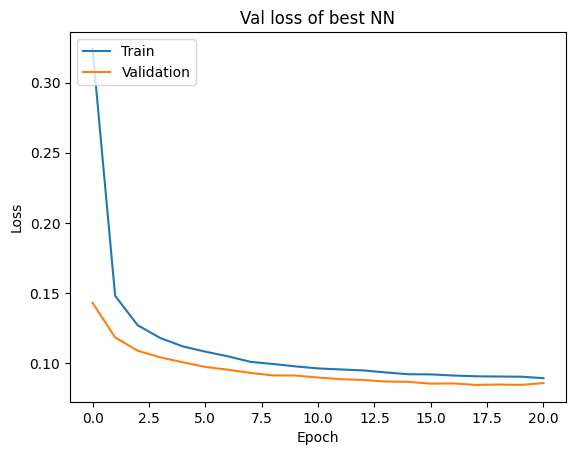

In [ ]:
plt.plot(best_history.history['loss']) 
plt.plot(best_history.history['val_loss']) 
plt.title('Val loss of best NN') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

Retrain on the development set, by taking the best model and test it on the test set.

In [ ]:
# Builds NN architecture based on the best nn
model = createModel(layersConfig[index_best_nn][0],layersConfig[index_best_nn][1],"relu","sigmoid")
model.compile(optimizer='adam',
                  loss=binary_crossentropy, # suitable for binary classification
                  metrics=['accuracy']) # accuracy on test set to maximize

# Train the model on the development set
final_history = model.fit(X_sc_trvl, y_trvl, validation_data = (X_sc_test, y_test), epochs=20, batch_size=32, verbose=0)

# Evaluate the model on the test set
y_pred_test = np.rint(model.predict(X_sc_test, verbose=0))

[42, 12]
[<keras.src.layers.core.dense.Dense object at 0x00000266BF24CCD0>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266BF24EB00>, <keras.src.layers.core.dense.Dense object at 0x00000266B98B67A0>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266B98B67D0>, <keras.src.layers.core.dense.Dense object at 0x00000266B98B4D30>, <keras.src.layers.core.dense.Dense object at 0x00000266B98B60E0>]


In [ ]:
report_scores(y_test, y_pred_test)

              precision    recall  f1-score   support

 non-killing       0.99      0.98      0.99     21553
     killing       0.94      0.96      0.95      6578

    accuracy                           0.98     28131
   macro avg       0.97      0.97      0.97     28131
weighted avg       0.98      0.98      0.98     28131



## Ensemble methods

### Random Forest

#### Grid search for parameter setting

In order to find the best parameters we use a grid search.
The parameters values we want to find are the following.

In [ ]:
params = {
    "unique_entry": {
    'max_depth': [5, 15, None],
    'max_features': ['log2', None],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [32, 64, 128],
    "bootstrap": [True, False],
    "criterion": ["entropy", "gini"],
    "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2} ]
    }}

best_rf = do_sklearn_GridSearchCV("RandomForestClassifier",RandomForestClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END .................................................... total time=  10.3s
[CV] END .................................................... total time=  10.5s
[CV] END .................................................... total time=  10.9s
[CV] END .................................................... total time=   9.7s
[CV] END .................................................... total time=  10.3s


We run the classifier and compute the perfomance scores.

CV best configuration for RandomForestClassifier:
best parameters {}
Mean accuracy train set: 0.999992382294548 +/- 3.8088527262552135e-06
Mean precision train set: 1.0 +/- 0.0
Mean recall train set: 0.9999674214041374 +/- 1.628929793127121e-05
Mean f1 train set: 0.9999837103703854 +/- 8.144814807264922e-06
Mean roc_auc train set: 1.0 +/- 0.0


Mean accuracy validation set: 0.981641321948101 +/- 0.0007511800122870125
Mean precision validation set: 0.9799129123245696 +/- 0.0013065745846530645
Mean recall validation set: 0.9407721127219417 +/- 0.0030362831874070064
Mean f1 validation set: 0.9599407325250787 +/- 0.001688847195041493
Mean roc_auc validation set: 0.9966432368685391 +/- 0.0003746763867394355


Testing:


              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.98      0.95      0.97     13155

    accuracy                           0.98     56261
   macro avg       0.98      0.97      0.98     56261
weighted avg       0.98      0.98      0.98     56261



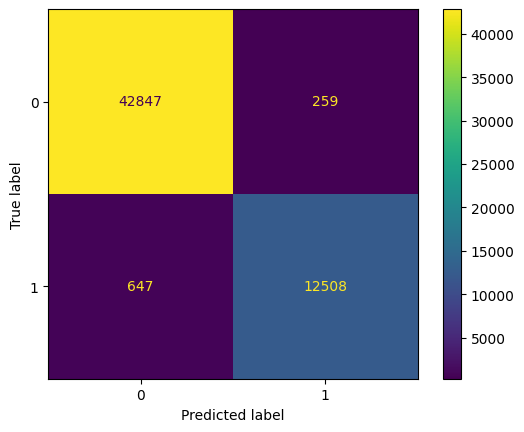

In [ ]:
print_metrics_cv(best_rf,"RandomForestClassifier")
print("Testing:")
test_pred_rf = best_rf.predict(X_sc_test)

print_report_score(y_test,test_pred_rf)
print_confusion_matrix(y_test,test_pred_rf,best_rf)

Oversampling

In [ ]:
best_rf_ov = do_sklearn_GridSearchCV("RandomForestClassifier_OV",RandomForestClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,3,X_sc_trvl_oversampled,y_trvl_oversampled)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


CV best configuration for RandomForestClassifier_OV:
best parameters {}
Mean accuracy train set: 0.7472869350543025 +/- 0.0035881674653820204
Mean precision train set: 0.6755262791363921 +/- 0.0031232752368840237
Mean recall train set: 0.9517439259906961 +/- 0.0013639834406489074
Mean f1 train set: 0.7901899694428481 +/- 0.002579256998283355
Mean roc_auc train set: 0.8957640153162556 +/- 0.0009369164146972369


Mean accuracy validation set: 0.7469724862531922 +/- 0.005159216115391393
Mean precision validation set: 0.6752703022472477 +/- 0.004355558191444009
Mean recall validation set: 0.9515897879299813 +/- 0.002372455244529954
Mean f1 validation set: 0.7899607586952313 +/- 0.0037909706247199687
Mean roc_auc validation set: 0.8956185014373903 +/- 0.001499188440156002


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.97      0.96      0.97     13155

    accuracy                           0.99    

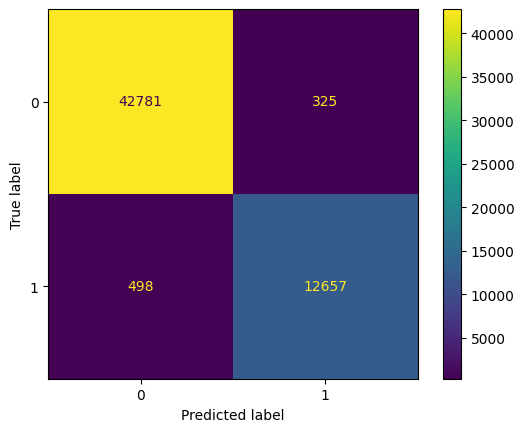

In [ ]:
print_metrics_cv(best_gnb_balanced_ov,"RandomForestClassifier_OV")

print("Testing:")
test_pred_rf_over = best_rf_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_rf_over)
print_confusion_matrix(y_test,test_pred_rf_over,best_rf_ov)

undersampling

In [ ]:
best_rf_und = do_sklearn_GridSearchCV("RandomForestClassifier_UN",RandomForestClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
#plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_rf.values, s=25, cmap='YlGn')


In [ ]:
best_rf_und = do_sklearn_GridSearchCV("RandomForestClassifier_UN",RandomForestClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
#plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_rf.values, s=25, cmap='YlGn')


In [ ]:
best_rf_und = do_sklearn_GridSearchCV("RandomForestClassifier_UN",RandomForestClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
#plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_rf.values, s=25, cmap='YlGn')


CV best configuration for RandomForestClassifier_UN:
best parameters {}
Mean accuracy train set: 0.7472869350543025 +/- 0.0035881674653820204
Mean precision train set: 0.6755262791363921 +/- 0.0031232752368840237
Mean recall train set: 0.9517439259906961 +/- 0.0013639834406489074
Mean f1 train set: 0.7901899694428481 +/- 0.002579256998283355
Mean roc_auc train set: 0.8957640153162556 +/- 0.0009369164146972369


Mean accuracy validation set: 0.7469724862531922 +/- 0.005159216115391393
Mean precision validation set: 0.6752703022472477 +/- 0.004355558191444009
Mean recall validation set: 0.9515897879299813 +/- 0.002372455244529954
Mean f1 validation set: 0.7899607586952313 +/- 0.0037909706247199687
Mean roc_auc validation set: 0.8956185014373903 +/- 0.001499188440156002


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.97      0.96      0.97     13155

    accuracy                           0.99    

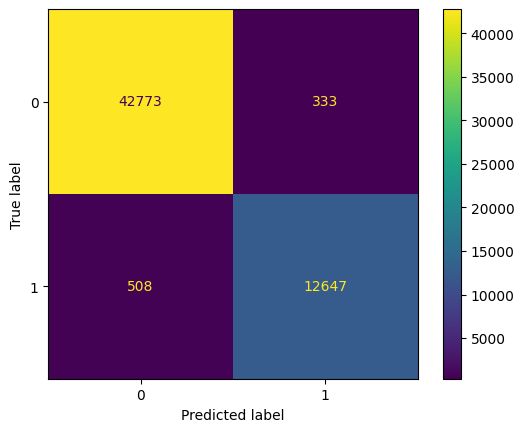

In [ ]:
print_metrics_cv(best_gnb_balanced_ov,"RandomForestClassifier_UN")

print("Testing:")
test_pred_rf_und = best_rf_und.predict(X_sc_test)

print_report_score(y_test,test_pred_rf_und)
print_confusion_matrix(y_test,test_pred_rf_und,best_rf_und)

### AdaBoost

Grid search AdaBoost

In [ ]:

def getAdaBoostBaseAlgo(num):
    if num == 0:
        return DecisionTreeClassifier(max_depth=5)
    elif num == 1:
        return SVC(kernel='rbf')
    elif num == 2:
        return RandomForestClassifier(max_depth=5)
    elif num == 3:
        return LogisticRegression()
                


In [ ]:
params = {
    "unique_entry":{
    'estimator': [getAdaBoostBaseAlgo(0),getAdaBoostBaseAlgo(1),getAdaBoostBaseAlgo(2),getAdaBoostBaseAlgo(3)],
    'n_estimators': [10,30,100], # The maximum number of estimators at which boosting is terminated.
    'learning_rate': [1,0.1],
    'random_state': [42],
    }
    }
best_ada_boost = do_sklearn_GridSearchCV("AdaBoostClassifier",AdaBoostClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


CV best configuration for AdaBoostClassifier:
best parameters {}
Mean accuracy train set: 0.9656022163767272 +/- 0.000552289984049151
Mean precision train set: 0.9845980054896895 +/- 0.002094314501342669
Mean recall train set: 0.8664521909105718 +/- 0.0027274968952139974
Mean f1 train set: 0.921749807047674 +/- 0.001331842809650927
Mean roc_auc train set: 0.9957042765084871 +/- 0.00010924750544593186


Mean accuracy validation set: 0.9653851232028167 +/- 0.0015436644230474575
Mean precision validation set: 0.9841238879446479 +/- 0.0018470343737416474
Mean recall validation set: 0.865939078025737 +/- 0.0069698401600212755
Mean f1 validation set: 0.9212390757030897 +/- 0.0037937212861665496
Mean roc_auc validation set: 0.9955492867529762 +/- 0.0002908172245548448


Testing:
              precision    recall  f1-score   support

   NotKilled       0.96      1.00      0.98     43106
    isKilled       0.98      0.87      0.92     13155

    accuracy                           0.97     56261

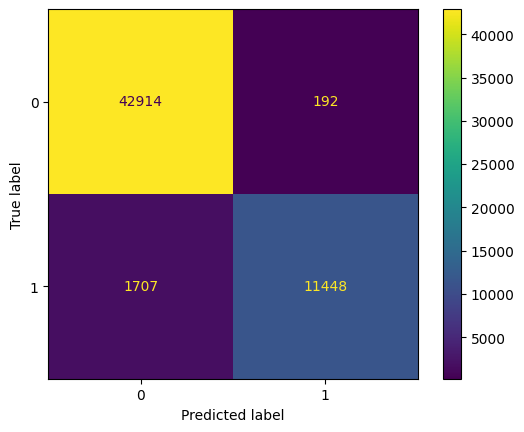

In [ ]:
print_metrics_cv(best_ada_boost,"AdaBoostClassifier")
print("Testing:")
test_pred_ada_boost = best_ada_boost.predict(X_sc_test)

print_report_score(y_test,test_pred_ada_boost)
print_confusion_matrix(y_test,test_pred_ada_boost,best_ada_boost)

Oversampling

In [ ]:
best_ada_boost_ov = do_sklearn_GridSearchCV("AdaBoostClassifier_OV",AdaBoostClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


CV best configuration for AdaBoostClassifier_OV:
best parameters {}
Mean accuracy train set: 0.9735590811594964 +/- 0.0012201361355250512
Mean precision train set: 0.9868393443904301 +/- 0.0005547711576688695
Mean recall train set: 0.9599191726798655 +/- 0.0019934095522113433
Mean f1 train set: 0.9731924750601337 +/- 0.001257206335518299
Mean roc_auc train set: 0.9956742403819426 +/- 5.975593505442413e-05


Mean accuracy validation set: 0.9735081124442317 +/- 0.00127796892476267
Mean precision validation set: 0.9867042635179051 +/- 0.0009242597209341455
Mean recall validation set: 0.9599514770582177 +/- 0.0020365875755922283
Mean f1 validation set: 0.9731431696306793 +/- 0.0013123026908192722
Mean roc_auc validation set: 0.9956327291221518 +/- 0.00017370587718313756


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.96      0.96      0.96     13155

    accuracy                           0.98     

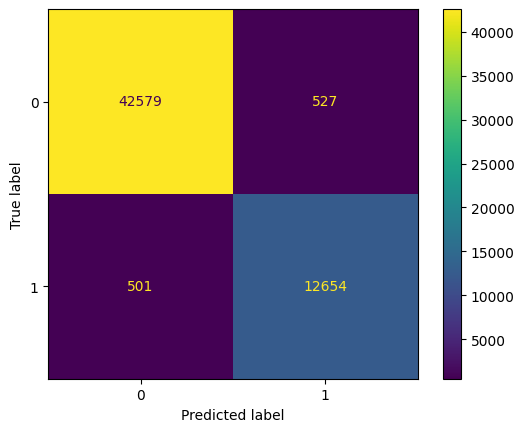

In [ ]:
print_metrics_cv(best_ada_boost_ov,"AdaBoostClassifier_OV")
print("Testing:")
test_pred_ada_boost_ov = best_ada_boost_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_ada_boost_ov)
print_confusion_matrix(y_test,test_pred_ada_boost_ov,best_ada_boost_ov)

Undersampling

In [ ]:
best_ada_boost_und = do_sklearn_GridSearchCV("AdaBoostClassifier_UN",AdaBoostClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


CV best configuration for AdaBoostClassifier_UN:
best parameters {}
Mean accuracy train set: 0.9735590811594964 +/- 0.0012201361355250512
Mean precision train set: 0.9868393443904301 +/- 0.0005547711576688695
Mean recall train set: 0.9599191726798655 +/- 0.0019934095522113433
Mean f1 train set: 0.9731924750601337 +/- 0.001257206335518299
Mean roc_auc train set: 0.9956742403819426 +/- 5.975593505442413e-05


Mean accuracy validation set: 0.9735081124442317 +/- 0.00127796892476267
Mean precision validation set: 0.9867042635179051 +/- 0.0009242597209341455
Mean recall validation set: 0.9599514770582177 +/- 0.0020365875755922283
Mean f1 validation set: 0.9731431696306793 +/- 0.0013123026908192722
Mean roc_auc validation set: 0.9956327291221518 +/- 0.00017370587718313756


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.96      0.96      0.96     13155

    accuracy                           0.98     

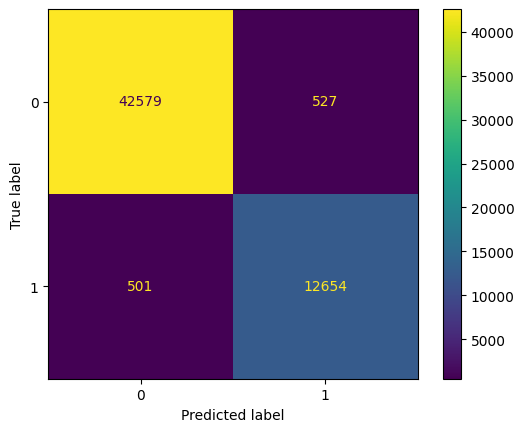

In [ ]:
print_metrics_cv(best_ada_boost_und,"AdaBoostClassifier_UN")
print("Testing:")
test_pred_ada_boost_und = best_ada_boost_und.predict(X_sc_test)

print_report_score(y_test,test_pred_ada_boost_und)
print_confusion_matrix(y_test,test_pred_ada_boost_und,best_ada_boost_und)

In [ ]:
#plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_ada_boost.values, s=25, cmap='YlGn')

In [ ]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_ada_boost)
auc = metrics.roc_auc_score(y_test, test_pred_ada_boost)
plt.plot(fpr,tpr,label="AdaBoost, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_rf)
auc = metrics.roc_auc_score(y_test, test_pred_rf)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_dt)
auc = metrics.roc_auc_score(y_test, test_pred_dt)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_knn)
auc = metrics.roc_auc_score(y_test, test_pred_gnb)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_svm)
auc = metrics.roc_auc_score(y_test, test_pred_gnb)
plt.plot(fpr,tpr,label="SVM, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_gnb)
auc = metrics.roc_auc_score(y_test, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

plt.legend(loc=0)